# Откуда берутся датасеты? Практический проект по сбору данных и работе с текстами

**Цель:** В этом домашнем задании вам предстоит обойти все ловушки серверов, пробраться сквозь страницы html-код, собрать себе свой собственный датасет и натренировать на нём модель.

## [Часть 1. Парсинг](#part-1)

По аналогии с занятием, возьмите интересующий вас сайт, на котором можно пособирать какие-то данные (и при этом API не предоставляется).

Идеальный датасет должен иметь текстовое описание некоторого объекта и некоторую целевую переменную, соответствующую этому объекту. Например:

- Сайт новостей: текстовое описание - сама новость, целевая переменная - количество просмотров новости (можно поделить на число дней с момента даты публикации, чтобы получить “среднее число просмотров в день”)
- Сайт с товарами/книгами/фильмами: текстовое описание товара/книги/фильма + средний рейтинг в качестве целевой переменной
- Блоги - тексты заметок + число просмотров
- И любые другие ваши идеи, которые подходят под такой формат

Напишите свой парсер, который будет бегать по страничкам и автоматически что-то собирать.

Не забывайте, что парсинг - это ответственное мероприятие, поэтому не бомбардируйте несчастные сайты слишком частыми запросами (можно ограничить число запросов в секунду при помощи time.sleep(0.3), вставленного в теле цикла).

## [Часть 2. NLP](#part-2)

1. Разбейте собранные данные на train/test, отложив 20-30% наблюдений для тестирования.
2. Примените tf-idf преобразование для текстового описания. Используйте как отдельные токены, так и биграммы, отсейте стоп-слова, а также слова, которые встречаются слишком редко или слишком часто (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена.
3. Если в вашем датасете целевая переменная непрерывная (например, среднее число просмотров в день), то воспользуйтесь линейной регрессией, если дискретная (положительный/отрицательный отзыв), то логистической.
4. Постройте регрессию с настройкой параметра регуляризации, оцените качество при помощи соответствующих задаче метрик.
5. Визуализируйте получившиеся коэффициенты регрессии (возьмите топ-50 слов). Проинтерпретируйте результаты.

P.S. Если с парсингом не задалось или данных собралось слишком мало - не отчаивайтесь, главное, что ваш парсер собрал хоть что-то! А для второй части задания можно скачать данные по отзывам на фильмы с сайта IMDB (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), в которых для каждого отзыва поставлена семантическая оценка - "позитивный" или "негативный". 

## Критерии оценки

- Получилось написать работающий парсер - 4 балла
- Предобработка текста при помощи tf-idf - 2 балла
- Построение моделей и визуализация результатов - 4 балла

<a id="part-1"></a>
## Часть 1. Парсинг

In [1]:
import requests
import numpy as np
import pandas as pd
import time
import re

from bs4 import BeautifulSoup

Рассмотрим сайт новостей про сериалы для парсинга (https://myshows.me/news/). Текстовое описание - описание новости, целевая переменная - количество комментариев.

In [2]:
page_link = 'https://myshows.me/news/?page=0'

### 1.1 Подготовка

Загрузим стартовую страничку новостей с первой страницей.

In [3]:
response = requests.get(page_link, headers=
                       {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:80.0) Gecko/20100101 Firefox/80.0'})
html = response.content
html[:1000]

b'<!DOCTYPE html>\n<html lang="ru">\n<head>\n    <meta charset="UTF-8">\n    <title>\xd0\x9d\xd0\xbe\xd0\xb2\xd0\xbe\xd1\x81\xd1\x82\xd0\xb8 \xd1\x81\xd0\xb5\xd1\x80\xd0\xb8\xd0\xb0\xd0\xbb\xd0\xbe\xd0\xb2</title>\n    <link rel="stylesheet" type="text/css" href="https://myshows.me/shared/minify.php?583f965a&amp;files=/shared/css/fe/styles.css,/shared/css/fe/styles-custom.css" />    <meta name="viewport" content="width=1200">\n    <meta name="keywords" content="" />\n    <meta name="description" content="" />\n\n    <link rel="canonical" href="https://myshows.me/news/">\n        <link rel="alternate" hreflang="ru" href="https://myshows.me/news/?page=0" />\n        <link rel="alternate" hreflang="en" href="https://en.myshows.me/news/" />\n        <link rel="alternate" hreflang="uk" href="https://ua.myshows.me/news/" />\n        <link rel="alternate" media="only screen and (max-width: 640px)" href="https://myshows.me/m/news/"/>        <link rel="image_src" href="https://myshows.me/shared

Загрузим результат в `BeautifulSoup` и построим объект на основе `html`-страницы.

In [4]:
soup = BeautifulSoup(html,'html.parser')
soup.html.head.title

<title>Новости сериалов</title>

Теперь построим список ссылок на каждую новость со страницы.

In [5]:
articles_links = [link.attrs['href'] for link in 
              soup.findAll(lambda tag: tag.name == 'a' and tag.get('class') == ['_sideName'])]

articles_links

['/news/1449/kak-sozdat-utopiyu-dizayn-dekoraciy-kserialu-divnyy-novyy-mir/',
 '/news/1451/11-y-sezon-stanet-poslednim-dlya-hodyachih-mertvecov/',
 '/news/1450/sarik-andreasyan-rabotaet-nad-serialom-pro-chikatilo-dlya-okko/',
 '/news/1441/vse-chto-nuzhno-znat-onominantah-naluchshiy-dramaticheskiy-serial-emmi-2020/',
 '/news/1448/vyshel-finalnyy-treyler-sestry-retched-murphy/',
 '/news/1447/fanaty-massovo-zanizhayut-reyting-vtorogo-sezona-pacanov-iz-za-togo-chto-epizody-vyhodyat-raz-vnedelyu/',
 '/news/1446/multserial-bratya-ventura-zakryli-posle-sedmogo-sezona/',
 '/news/1445/posmotrite-treyler-novogo-seriala-start-sherlok-vrossii/',
 '/news/1444/chto-posmotret-na-etoy-nedele-7-13-sept/',
 '/news/1440/vyshel-treyler-vtorogo-sezona-francuzskogo-seriala-semeynyy-biznes/',
 '/news/1439/netflix-pokazal-tizer-emily-in-paris-slili-kollinz-vglavnoy-roli/',
 '/news/1437/glavnuyu-rol-vseriale-amazon-odzheke-richere-sygraet-alan-ritchson/',
 '/news/1438/anna-feris-pokidaet-sitkom-mamasha-posle-s

Создадим функцию, которая по номеру страницы будет возвращать список всех ссылок на ней.

In [6]:
def getPageLinks(page_number):
    """
        Возвращает список ссылок на новости, полученный с текущей страницы
        
        Параметры:
            page_number: int/string - номер страницы для парсинга            
    """
    # составляем ссылку на страницу поиска
    page_link = 'https://myshows.me/news/?page={}'.format(page_number)
    
    # запрашиваем данные по ней
    response = requests.get(page_link, headers=
                            {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:80.0) Gecko/20100101 Firefox/80.0'})
    
    if not response.ok:
        # если сервер нам отказал, вернем пустой лист для текущей страницы
        print('Сервер обиделся и ничего не вернул')
        return [] 
    
    # получаем содержимое страницы и переводим в суп
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # ищем ссылки на новости и формируем полные ссылки
    articles_links = soup.findAll(lambda tag: tag.name == 'a' and tag.get('class') == ['_sideName'])
    articles_links = ['https://myshows.me' + link.attrs['href'] for link in articles_links]
    
    return articles_links

Протестируем функцию и убедимся, что она работает как положено.

In [7]:
articles_links = getPageLinks(2)
articles_links

['https://myshows.me/news/1410/hbo-max-vypustil-novyy-treyler-fantasticheskoy-dramy-vospitannye-volkami-ridli-skotta-/',
 'https://myshows.me/news/1409/vyshli-pervye-foto-iposter-vtorogo-sezona-prizraki-doma-naholme/',
 'https://myshows.me/news/1408/posmotrite-treyler-dramy-pravilo-komi-sbrendanom-glisonom-vroli-donalda-trampa/',
 'https://myshows.me/news/1406/chto-posmotret-na-etoy-nedele-24-30-avs/',
 'https://myshows.me/news/1405/posmotrite-treyler-sedmogo-sezona-seriala-flesh/',
 'https://myshows.me/news/1404/sky-vypustil-treyler-seriala-i-hate-suzie-sbilli-payper/',
 'https://myshows.me/news/1403/obshhestvo-imne-eto-nenravitsya-ostanutsya-bez-vtoryh-sezonov/',
 'https://myshows.me/news/1402/penny-dreadful-city-of-angeles-cancelled/',
 'https://myshows.me/news/1401/novyy-dokumentalnyy-serial-all-or-nothing-otottenheme-ozvuchil-tom-hardi/',
 'https://myshows.me/news/1400/chetvertyy-sezon-korony-vyydet-15noyabrya/',
 'https://myshows.me/news/1399/chto-smotret-na-sleduyushhey-nedele-p

Теперь, когда все готово к штурму сервера, подготовим парсер для отдельной страницы с новостью. Будет извлекать текстовое описание и количество оставленных под новостью комментариев.

In [8]:
news_page = 'https://myshows.me/news/1407/7-samyh-uspeshnyh-serialov-netflix-etogo-leta/'

response = requests.get(news_page, headers=
                       {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:80.0) Gecko/20100101 Firefox/80.0'})

soup = BeautifulSoup(response.content, 'html.parser')

Заголовок новости находится в теге `h1` внутри тега `main`.

In [9]:
main = soup.main
title = main.h1.string
title

'7 самых успешных сериалов Netflix этого лета'

Далее короткое описание новости находится в параграфе с классом `fsBigX`. Также удалим лишние пробелы в начале и конце строки и заменим неразрывный пробел обычным пробелом.

In [10]:
short_description = main.find('p', attrs={'class' : 'fsBigX'}) \
    .get_text(strip=True)    
short_description

'«Монахиня-воин», документалка о\xa0Майкле Джордане, трэвел-шоу с\xa0Заком Эфроном и\xa0еще четыре самых популярных шоу лета.'

Создадим функцию, которая будет декодировать Unicode символы

In [11]:
def decode_unicode(text):
    return text.replace(u'\xa0', ' ')  \
               .replace(u'\u202f', '') \
               .replace('\n', ' ')

In [12]:
short_description = decode_unicode(short_description)
short_description

'«Монахиня-воин», документалка о Майкле Джордане, трэвел-шоу с Заком Эфроном и еще четыре самых популярных шоу лета.'

Далее содержимое статьи находится в блоке с классом `fsBig`. Возьмем текст из всех параграфов.

In [13]:
decode_unicode(main.find('div', attrs={'class' : 'fsBig'}) \
    .get_text(strip=True))

'После того, как Netflix начал публиковать топ-10 самых популярных сериалов платформы, у зрителей впервые появилось представление о том, какие проекты становятся популярными на стриминговом сервисе — раньше Netflix такую информацию скрывал. Издание Forbes на основе этих рейтингов составилотоп самых успешных сериалов этого лета. Точнее, лишь части лета: летний сезон на ТВ длится с 20 июня по 20 сентября.Расскажем вам о семи самых популярных шоу из рейтинга издания — на случай, если вы что-то пропустили.1. «Неразгаданные тайны» / Unsolved MysteriesДетектив | 3.68 из 5 на MyShows | 4 часа 45 минутРемейк одноименного проекта 1988 годаUnsolved Mysteries. Зрителям рассказывают реальные случаи загадочных исчезновений, шокирующих убийств и паранормальных явлений. Расследуются дела, произошедшие не только в США, но и за рубежом.«Основная фишка сериала в том, что все случаи абсолютно реальны и многие дела открыты до сих пор. Порой зрители помогают найти новые доказательства или находятся новые с

В тексте статьи встречаются ссылки на добавление сериал в свой список. Их стоит исключить из парсинга.

In [14]:
main_div = main.find('div', attrs={'class' : 'fsBig'})
paragraphs_to_delete = main_div.findAll('p', string=re.compile("Добавить сериал"))
[paragraph.decompose() for paragraph in paragraphs_to_delete]

decode_unicode(main.find('div', attrs={'class' : 'fsBig'}).get_text())

' После того, как Netflix начал публиковать топ-10 самых популярных сериалов платформы, у зрителей впервые появилось представление о том, какие проекты становятся популярными на стриминговом сервисе — раньше Netflix такую информацию скрывал. Издание Forbes на основе этих рейтингов составило топ самых успешных сериалов этого лета. Точнее, лишь части лета: летний сезон на ТВ длится с 20 июня по 20 сентября. Расскажем вам о семи самых популярных шоу из рейтинга издания — на случай, если вы что-то пропустили. 1. «Неразгаданные тайны» / Unsolved Mysteries Детектив | 3.68 из 5 на MyShows | 4 часа 45 минут  Ремейк одноименного проекта 1988 года Unsolved Mysteries. Зрителям рассказывают реальные случаи загадочных исчезновений, шокирующих убийств и паранормальных явлений. Расследуются дела, произошедшие не только в США, но и за рубежом. «Основная фишка сериала в том, что все случаи абсолютно реальны и многие дела открыты до сих пор. Порой зрители помогают найти новые доказательства или находятс

Также исключим из текста оценки и длительность

In [15]:
paragraphs_to_delete = main_div.findAll(lambda tag: 
                                        tag.name == 'em' and 
                                        tag.parent.name == 'p' and 
                                        tag.parent.get('style') is None)
[paragraph.decompose() for paragraph in paragraphs_to_delete]

article = decode_unicode(main.find('div', attrs={'class' : 'fsBig'}).get_text())
article

' После того, как Netflix начал публиковать топ-10 самых популярных сериалов платформы, у зрителей впервые появилось представление о том, какие проекты становятся популярными на стриминговом сервисе — раньше Netflix такую информацию скрывал. Издание Forbes на основе этих рейтингов составило топ самых успешных сериалов этого лета. Точнее, лишь части лета: летний сезон на ТВ длится с 20 июня по 20 сентября. Расскажем вам о семи самых популярных шоу из рейтинга издания — на случай, если вы что-то пропустили. 1. «Неразгаданные тайны» / Unsolved Mysteries   Ремейк одноименного проекта 1988 года Unsolved Mysteries. Зрителям рассказывают реальные случаи загадочных исчезновений, шокирующих убийств и паранормальных явлений. Расследуются дела, произошедшие не только в США, но и за рубежом. «Основная фишка сериала в том, что все случаи абсолютно реальны и многие дела открыты до сих пор. Порой зрители помогают найти новые доказательства или находятся новые свидетели. Все происходит в реальной жизн

Теперь соединим заголовок, короткое и подробное описание новости.

In [16]:
full_text = title + '. ' + short_description + ' '+ article
full_text

'7 самых успешных сериалов Netflix этого лета. «Монахиня-воин», документалка о Майкле Джордане, трэвел-шоу с Заком Эфроном и еще четыре самых популярных шоу лета.  После того, как Netflix начал публиковать топ-10 самых популярных сериалов платформы, у зрителей впервые появилось представление о том, какие проекты становятся популярными на стриминговом сервисе — раньше Netflix такую информацию скрывал. Издание Forbes на основе этих рейтингов составило топ самых успешных сериалов этого лета. Точнее, лишь части лета: летний сезон на ТВ длится с 20 июня по 20 сентября. Расскажем вам о семи самых популярных шоу из рейтинга издания — на случай, если вы что-то пропустили. 1. «Неразгаданные тайны» / Unsolved Mysteries   Ремейк одноименного проекта 1988 года Unsolved Mysteries. Зрителям рассказывают реальные случаи загадочных исчезновений, шокирующих убийств и паранормальных явлений. Расследуются дела, произошедшие не только в США, но и за рубежом. «Основная фишка сериала в том, что все случаи а

Текстовое описание теперь готово. Осталось взять количество комментариев.

In [17]:
main.find('sup', attrs={'id' : 'total-comments-count'}).string

'25'

Теперь создадим функцию, которая на основе странички вернет текстовое описание и количество комментариев.

In [18]:
def getData(soup):
    """
        Возвращает tuple с заголовком, текстовым описанием новости и количеством комментариев к ней.
    """
    # в теге main находится все содержимое страницы
    main = soup.main
    
    # сохраняем заголовок новости
    title = main.h1.string
    
    # краткое описание новости
    short_description = decode_unicode(main.find('p', attrs={'class' : 'fsBigX'}).get_text(strip=True))
    
    # полный текст новости находится под тегов div с классом fsBig
    main_div = main.find('div', attrs={'class' : 'fsBig'})
    
    # очищаем содержимое новости от ссылок на добавление в личный аккаунт   
    paragraphs_to_delete = main_div.findAll('p', string=re.compile("Добавить сериал"))

    # удаляем строчки с жанрами, оценками и длительностью
    paragraphs_to_delete = paragraphs_to_delete + \
        main_div.findAll(lambda tag: 
                                tag.name == 'em' and 
                                tag.parent.name == 'p' and 
                                tag.parent.get('style') is None)
    
    # удаляем теги
    [paragraph.decompose() for paragraph in paragraphs_to_delete]
    
    # сохраняем полный текст новости
    article = decode_unicode(main.find('div', attrs={'class' : 'fsBig'}).get_text())
    
    # соединяем весь текст
    full_text = title + '. ' + short_description + ' '+ article
    
    # сохраняем количество комментариев на странице
    comments_count = main.find('sup', attrs={'id' : 'total-comments-count'}).string

    return title, full_text, comments_count

Далее создадим функцию, которая будет по заданному адресу страницы получать ее содержимое и количество комментариев.

In [19]:
def getArticleData(article_page):
    """
        Запрашивает данные по странице, возвращает обработанный словарь с данными.
        
        article_page: string
            ссылка на страницу со статьей
    """
    
    # запрашиваем данные по ссылке
    response = requests.get(article_page, headers=
                           {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:80.0) Gecko/20100101 Firefox/80.0'})
    
    if not response.ok:
        # если сервер нам отказал, вернем статус ошибки 
        return response.status_code
    
    # получаем содержимое страницы и переводим в суп
    html = response.content
    soup = BeautifulSoup(html,'html.parser')

    # парсим информацию
    title, full_text, comments_count = getData(soup=soup)

    # составляем словарь, в котором будут хранится все полученные и обработанные данные
    data_row = {
        "title": title,
        "full_text": full_text,
        "comments_count": comments_count,
    }

    return data_row

Подготовим табличку, куда будем записывать данные по всем страничкам.

In [20]:
data = pd.DataFrame(columns=['title', 'full_text', 'comments_count'])

Теперь попробуем загрузить страницу и добавить строчку в таблицу.

In [21]:
data_row = getArticleData('https://myshows.me/news/1407/7-samyh-uspeshnyh-serialov-netflix-etogo-leta/')
data = data.append(data_row, ignore_index=True)
data

,title,full_text,comments_count
0,7 самых успешных сериалов Netflix этого лета,7 самых успешных сериалов Netflix этого лета. ...,25


### 1.2 Парсинг
Теперь создадим цикл, в котором будет загружать страницу с новостями и парсить каждую ссылку на ней.

In [22]:
from tqdm.notebook import tqdm

# Если уже распарсили и подготовили csv с данными, то повторно парсить не нужно
PARSE = False

if PARSE:
    data = pd.DataFrame(columns=['title', 'full_text', 'comments_count'])
    for page_number in tqdm(range(70), desc='Pages'):
        articles_links = getPageLinks(page_number)  

        for article_link in tqdm(articles_links, desc='Articles', leave=False):
            data_row = getArticleData(article_link)           
            data = data.append(data_row, ignore_index=True)
            time.sleep(5) # одну страничку в пять секунд

        data.to_csv('NEWS_{}.csv'.format(page_number))

    data.to_csv('NEWS_full.csv')

In [23]:
data = pd.read_csv('NEWS_full.csv', index_col=0)
data.head()

,title,full_text,comments_count
0,Что посмотреть на этой неделе? Премьеры сериал...,Что посмотреть на этой неделе? Премьеры сериал...,4.0
1,Вышел трейлер второго сезона французского сери...,Вышел трейлер второго сезона французского сери...,NaN
2,Netflix показал тизер Emily in Paris с Лили Ко...,Netflix показал тизер Emily in Paris с Лили Ко...,10.0
3,Главную роль в сериале Amazon о Джеке Ричере с...,Главную роль в сериале Amazon о Джеке Ричере с...,3.0
4,Анна Фэрис покидает ситком «Мамаша» после семи...,Анна Фэрис покидает ситком «Мамаша» после семи...,10.0


<a id="part-2"></a>
## Часть 2. NLP
У нас теперь есть данные для моделирования. Заменим все пропуски в поле `comments_count` на нули.

In [24]:
data.isnull().sum()

title               0
full_text           0
comments_count    311
dtype: int64

In [25]:
data['comments_count'] = data['comments_count'].fillna(0)
data.head()

,title,full_text,comments_count
0,Что посмотреть на этой неделе? Премьеры сериал...,Что посмотреть на этой неделе? Премьеры сериал...,4.0
1,Вышел трейлер второго сезона французского сери...,Вышел трейлер второго сезона французского сери...,0.0
2,Netflix показал тизер Emily in Paris с Лили Ко...,Netflix показал тизер Emily in Paris с Лили Ко...,10.0
3,Главную роль в сериале Amazon о Джеке Ричере с...,Главную роль в сериале Amazon о Джеке Ричере с...,3.0
4,Анна Фэрис покидает ситком «Мамаша» после семи...,Анна Фэрис покидает ситком «Мамаша» после семи...,10.0


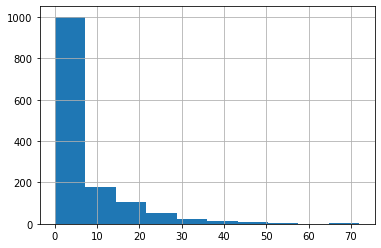

In [26]:
data['comments_count'].hist()

Как можно заметить в большинстве новостей комментариев нет либо их мало. Но есть и новости с большим обсуждением. Попробуем по текстовому описанию построить модель зависимости интереса пользователей к обсуждению от содержимого.

### 2.1 TF-IDF преобразование

Подготовим текст к обработке. Применим лемматизацию и отсеим стоп-слова.

Скачаем пакет с русскими стоп-словами.

In [27]:
import nltk

DOWNLOAD_STOPWORDS = False
if DOWNLOAD_STOPWORDS:
    nltk.download("stopwords")

In [28]:
from nltk.corpus import stopwords
from string import punctuation
from pymystem3 import Mystem

mystem = Mystem() 
stop_words = stopwords.words("russian")

Теперь создадим функцию, которая будет осуществлять предобработку текста.

In [29]:
def lemmatize_and_filter(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in stop_words \
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

Проверим работу функции на одной строке

In [30]:
data['full_text'].values[0]

'Что посмотреть на\xa0этой неделе? Премьеры сериалов 7\xa0— 13\xa0сентября. Шоу от режиссера «Классного мюзикла», драма о журналисте, расследующем свою собственную смерть, и комедия о материнстве с Кэтрин Райан.  7 сентября, понедельник — Записки юности / Record of Youth   Дорама расскажет о трех молодых людях, пытающихся построить карьеру в модельном бизнесе. Ан Чон Ха — трудолюбивая визажистка, Са Хе Джун — обычно парень, который хочет пробиться на вершину, Вон Хэ Хё — лучший друг Са Хе Джуна, популярный актер и модель, который переживает из-за того, что все считают, что он получил свою карьеру из-за богатой семьи. Объединяет ребят одно: они хотят во что бы то ни стало достичь цели.  9 сентября, среда — Очнувшийся / Woke   В центре сюжета шоу — Киф, афроамериканский иллюстратор, который наконец-то оказывается на пороге настоящего успеха и известности. Но неожиданный инцидент меняет все, и теперь Киф начинает мыслить совершенно иначе. Ему нужно будет справиться не только с новыми идея

Стоит применить функцию по очистке юникод символов.

In [31]:
data['full_text'] = data['full_text'].apply(lambda text: decode_unicode(text))
data['full_text'].values[0]

'Что посмотреть на этой неделе? Премьеры сериалов 7 — 13 сентября. Шоу от режиссера «Классного мюзикла», драма о журналисте, расследующем свою собственную смерть, и комедия о материнстве с Кэтрин Райан.  7 сентября, понедельник — Записки юности / Record of Youth   Дорама расскажет о трех молодых людях, пытающихся построить карьеру в модельном бизнесе. Ан Чон Ха — трудолюбивая визажистка, Са Хе Джун — обычно парень, который хочет пробиться на вершину, Вон Хэ Хё — лучший друг Са Хе Джуна, популярный актер и модель, который переживает из-за того, что все считают, что он получил свою карьеру из-за богатой семьи. Объединяет ребят одно: они хотят во что бы то ни стало достичь цели.  9 сентября, среда — Очнувшийся / Woke   В центре сюжета шоу — Киф, афроамериканский иллюстратор, который наконец-то оказывается на пороге настоящего успеха и известности. Но неожиданный инцидент меняет все, и теперь Киф начинает мыслить совершенно иначе. Ему нужно будет справиться не только с новыми идеями, запол

In [32]:
lemmatize_and_filter(data['full_text'].values[0])

'посмотреть неделя премьера сериал 7  —  13 сентябрь шоу режиссер  « классный мюзикл »,  драма журналист расследовать свой собственный смерть комедия материнство кэтрин райан 7 сентябрь понедельник  —  записка юность record of youth дорам рассказывать молодой человек пытаться построить карьера модельный бизнес ан чон ха  —  трудолюбивый визажистка са хе джуна  —  обычно парень который хотеть пробиваться вершина вон хэ хё  —  хороший друг са хе джуна популярный актер модель который переживать из-за считать получать свой карьера из-за богатый семья объединять ребята хотеть становиться достигать цель 9 сентябрь среда  —  очнуться woke центр сюжет шоу  —  киф афроамериканский иллюстратор который оказываться порог настоящий успех известность неожиданный инцидент менять весь киф начинать мыслить совершенно иначе нужно справляться новый идея заполонять голова неодушевленный предмет который начинать разговаривать путь разрушать карьера который труд построить 10 сентябрь четверг  —  джули призр

Сделаем теперь предобработку для всего датасета.

In [33]:
data_preprocessed = data.copy()
data_preprocessed['full_text'] = data['full_text'].apply(lambda text: lemmatize_and_filter(text))
data_preprocessed['full_text'].values[0]

'посмотреть неделя премьера сериал 7  —  13 сентябрь шоу режиссер  « классный мюзикл »,  драма журналист расследовать свой собственный смерть комедия материнство кэтрин райан 7 сентябрь понедельник  —  записка юность record of youth дорам рассказывать молодой человек пытаться построить карьера модельный бизнес ан чон ха  —  трудолюбивый визажистка са хе джуна  —  обычно парень который хотеть пробиваться вершина вон хэ хё  —  хороший друг са хе джуна популярный актер модель который переживать из-за считать получать свой карьера из-за богатый семья объединять ребята хотеть становиться достигать цель 9 сентябрь среда  —  очнуться woke центр сюжет шоу  —  киф афроамериканский иллюстратор который оказываться порог настоящий успех известность неожиданный инцидент менять весь киф начинать мыслить совершенно иначе нужно справляться новый идея заполонять голова неодушевленный предмет который начинать разговаривать путь разрушать карьера который труд построить 10 сентябрь четверг  —  джули призр

Сохраним в $X$ все колонки признаки, а в $y$ $-$ целевую переменную.

In [34]:
X = data_preprocessed['full_text']
y = data_preprocessed['comments_count']

X.shape, y.shape

((1394,), (1394,))

Разобьем выборку на train/test, отложив $30\%$ наблюдений для тестирования.

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((975,), (419,), (975,), (419,))

Теперь применим `tf-idf` преобразование для описания новости.

In [36]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(max_df=0.7, min_df=5,
                              max_features=2987,
                              stop_words='english',
                              ngram_range=(1,2),
                              norm=None)

tfidf = tfidf_model.fit_transform(X_train).todense()
tfidf

CPU times: user 281 ms, sys: 7.86 ms, total: 289 ms
Wall time: 289 ms


matrix([[3.37260308, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 3.7563282 , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [37]:
tfidf_model.vocabulary_

{'властелин': 405,
 'кольцо': 1071,
 'отвечать': 1600,
 'сценарист': 2563,
 'весь': 357,
 'тяжкий': 2681,
 'продюсер': 1981,
 'игра': 910,
 'престол': 1923,
 'amazon': 76,
 'объявлять': 1517,
 'производственный': 2003,
 'команда': 1072,
 'проект': 1987,
 'состав': 2444,
 'очень': 1644,
 'громкий': 609,
 'имя': 937,
 'представлять': 1895,
 'творческий': 2602,
 'создатель': 2422,
 'опубликовывать': 1559,
 'видео': 384,
 'член': 2876,
 'съемочный': 2574,
 'группа': 610,
 'шоураннер': 2915,
 'джон': 698,
 'ди': 706,
 'патрик': 1666,
 'дженнифер': 684,
 'джейсон': 680,
 'джастин': 675,
 'странный': 2527,
 'дело': 646,
 'грань': 601,
 '13': 7,
 'причина': 1960,
 'почему': 1872,
 'режиссер': 2130,
 'первый': 1669,
 'эпизод': 2951,
 'голос': 584,
 'монстр': 1319,
 'мир': 1291,
 'период': 1690,
 'исполнительный': 960,
 'дикий': 708,
 'запад': 854,
 '10': 0,
 'брайан': 302,
 'художник': 2832,
 'костюм': 1118,
 'кейт': 1035,
 'будущее': 318,
 'постановщик': 1851,
 'рик': 2151,
 'звездный': 880,
 

Создадим табличку для дальнейшей работы.

In [38]:
train_data = pd.DataFrame(
    tfidf_model.fit_transform(X_train).todense(),
    columns=tfidf_model.get_feature_names()
)
train_data

,10,100,11,11 октябрь,12,12 апрель,12 ноябрь,13,13 причина,14,...,юный,юридический,юридический драма,являться,явно,язык,январь,январь 2020,японский,яркий
0,3.372603,0.0,0.000000,0.0,0.000000,0.0,0.0,3.501436,5.244405,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,3.501436,5.244405,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
971,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
972,0.000000,0.0,3.756328,0.0,3.693808,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,5.244405,0.0,0.0,0.0,0.0
973,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [39]:
test_data = pd.DataFrame(
    tfidf_model.transform(X_test).todense(),
    columns=tfidf_model.get_feature_names()
)
test_data

,10,100,11,11 октябрь,12,12 апрель,12 ноябрь,13,13 причина,14,...,юный,юридический,юридический драма,являться,явно,язык,январь,январь 2020,японский,яркий
0,0.000000,0.0,7.512656,0.0,7.387616,0.0,0.000000,10.504308,0.0,3.932219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,7.002872,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
416,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
417,10.117809,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.2 Построение модели регрессии

Воспользуемся моделью линейной регрессии и построим модель зависимости содержимого статьи на количество комментариев.

Создадим функцию, которая будет вычислять основные метрики качества.

In [40]:
from sklearn import metrics

metrics_table = pd.DataFrame({"error_type":["MAE", "MSE", "R2"]})
metrics_table.set_index("error_type")

""
error_type
MAE
MSE
R2


Построим модель линейнной регрессиию с помощью 

In [41]:
%%time

import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=Lasso(), 
                         param_grid={'alpha': np.arange(0.01, 10, 0.1)}, 
                         scoring='r2',                          
                         n_jobs=-1)
grid_search.fit(train_data, y_train)

print('Best Score: ', grid_search.best_score_)
print('Best Params: ', grid_search.best_params_)

y_pred = grid_search.predict(test_data)
regressor = grid_search.best_estimator_

metrics_table['Regressor'] = [
    metrics.mean_absolute_error(y_test, y_pred),
    metrics.mean_squared_error(y_test, y_pred),
    metrics.r2_score(y_test, y_pred)
]

metrics_table

Best Score:  0.06817217283853691
Best Params:  {'alpha': 0.6100000000000001}
CPU times: user 2.27 s, sys: 92.7 ms, total: 2.36 s
Wall time: 19.4 s


,error_type,Regressor
0,MAE,6.185950
1,MSE,84.337724
2,R2,0.188722


Построим график важности признаков (топ-50 слов).

In [42]:
train_data.columns[regressor.coef_!=0]

Index(['13', '2019', '2020 год', '2021', '31', 'amazon', 'cw', 'fi', 'marvel',
       'myshows', 'myshows час', 'pic', 'witcher', 'август', 'аниме', 'апрель',
       'бэтвумен', 'ведьмак', 'вселенная', 'второй', 'голливуд', 'девушка',
       'декабрь', 'десять', 'джексон', 'добавлять сериал', 'должный', 'дорам',
       'драма', 'закрывать', 'игра престол', 'из', 'история', 'июль', 'июнь',
       'камера', 'канал', 'книга', 'комикс', 'комментарий', 'конкретно',
       'контент', 'коронавирус', 'кэти', 'люцифер', 'май', 'мерфи', 'минута',
       'мистер', 'мистер робот', 'мочь', 'музыкальный', 'мультсериал',
       'несколько', 'нью', 'общество', 'объявлять', 'однако', 'озвучка',
       'отец', 'подросток который', 'пользователь', 'пост', 'почему',
       'принимать', 'продюсер', 'публикация', 'пытаться', 'решать', 'решение',
       'роль', 'сверхъестественный', 'сезон пацан', 'серия', 'симпсон',
       'сообщество', 'студия', 'сыграть', 'трейлер', 'третий', 'тюрьма',
       'убивать', '

Как видно ненулевых коэффициентов не очень много.

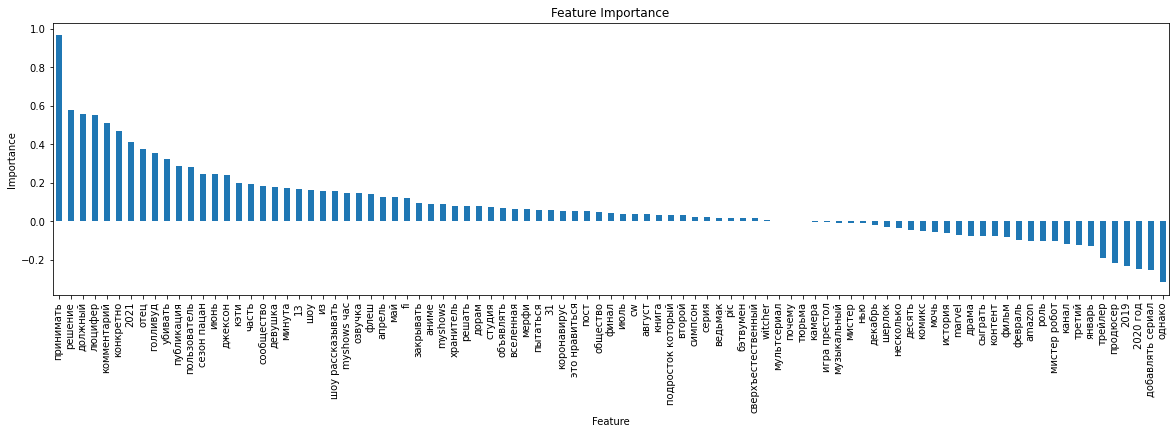

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

featureImportance = pd.DataFrame({"feature": train_data.columns[regressor.coef_!=0], 
                                  "importance": regressor.coef_[regressor.coef_!=0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)

featureImportance["importance"].plot(kind='bar', figsize=(20, 5));    
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

Как видно некоторые общие слова все же занимают лидирующее положение, но также можно отметить, что высоко обсуждение новостей о сериалах "Пацаны", "Люцифер" и другие.

Теперь попробуем все соединить в несколько функций и построить разные модели.

In [44]:
def load_data():
    '''
        Загружает сырые данные с новостями и количеством комментариев.
    '''
    data = pd.read_csv('NEWS_full.csv', index_col=0)
    data['comments_count'] = data['comments_count'].fillna(0)
    return data

def preprocess_data(data):
    '''
        Делает предобратку текста новости и ее заголовка - лемматизация и отсеивание стоп-слов
    '''
    data_preprocessed = data.copy()
    data_preprocessed['full_text'] = data['full_text'].apply(lambda text: lemmatize_and_filter(text))
    data_preprocessed['title'] = data['title'].apply(lambda text: lemmatize_and_filter(text))
    return data_preprocessed

def tf_idf(X_train, X_test, max_df=0.7, min_df=5, max_features=5000, ngram_range=(1,2)):
    '''
        Осуществляет tf-idf преобразование тренировочного и тестового наборов.
        Возвращает 2 новых датасета для тренировочного и тестового наборов.
    '''
    tfidf_model = TfidfVectorizer(max_df=max_df, min_df=min_df,
                                  max_features=max_features,
                                  stop_words='english',
                                  ngram_range=ngram_range,
                                  norm=None)

    train_data = pd.DataFrame(
        tfidf_model.fit_transform(X_train).todense(),
        columns=tfidf_model.get_feature_names()
    )
    
    test_data = pd.DataFrame(
        tfidf_model.transform(X_test).todense(),
        columns=tfidf_model.get_feature_names()
    )
    
    return train_data, test_data

def print_feature_importance(columns, importance):
    '''
        Отображает график важности признаков.
    '''
    featureImportance = pd.DataFrame({"feature": columns, 
                                      "importance": importance})

    featureImportance.set_index('feature', inplace=True)
    featureImportance.sort_values(["importance"], ascending=False, inplace=True)

    featureImportance["importance"].plot(kind='bar', figsize=(20, 5));    
    plt.title("Feature Importance")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.show()

def calc_metrics(y_test, y_pred):
    metrics_table = pd.DataFrame({"error_type":["MAE", "MSE", "R2"]})
    metrics_table.set_index("error_type")   
    metrics_table['Regressor'] = [
        metrics.mean_absolute_error(y_test, y_pred),
        metrics.mean_squared_error(y_test, y_pred),
        metrics.r2_score(y_test, y_pred)
    ]
    print(metrics_table)
    
def regression(data, feature_column_name, target_column_name, 
               max_df, min_df, max_features, ngram_range):
    '''
        Строит модель регрессии по заданной колонке датасета.
        Отображает график важности признаков.
    '''

    X = data[feature_column_name]
    y = data[target_column_name]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    train_data, test_data = tf_idf(X_train, X_test, max_df, min_df, max_features, ngram_range)
    
    grid_search = GridSearchCV(estimator=Lasso(), 
                         param_grid={'alpha': np.arange(0.01, 10, 0.1)}, 
                         scoring='r2',                          
                         n_jobs=-1)
    
    grid_search.fit(train_data, y_train)

    print('Best Score: ', grid_search.best_score_)
    print('Best Params: ', grid_search.best_params_)

    y_pred = grid_search.predict(test_data)    

    calc_metrics(y_test, y_pred)
    
    regressor = grid_search.best_estimator_
    print_feature_importance(train_data.columns[regressor.coef_!=0],
                             regressor.coef_[regressor.coef_!=0])
    
def load_data_and_process(feature_column_name, target_column_name, 
                          max_df=0.7, min_df=5, max_features=5000, ngram_range=(1,2)):
    data = load_data()
    data_preprocced = preprocess_data(data)
    regression(data_preprocced, feature_column_name, target_column_name, 
               max_df, min_df, max_features, ngram_range)

Best Score:  0.07167572222870491
Best Params:  {'alpha': 0.6100000000000001}
  error_type  Regressor
0        MAE   6.159481
1        MSE  82.858520
2         R2   0.202951


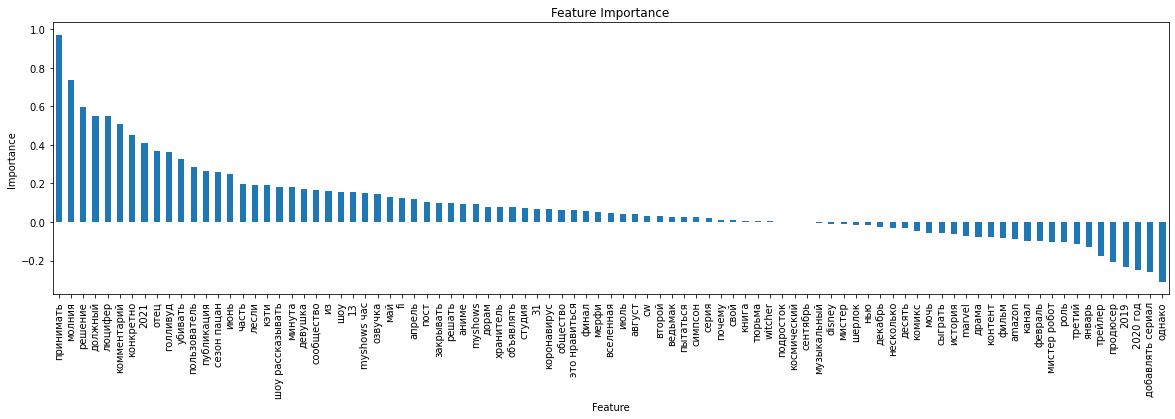

In [45]:
load_data_and_process('full_text', 'comments_count')

Best Score:  0.020354374449490176
Best Params:  {'alpha': 0.41000000000000003}
  error_type   Regressor
0        MAE    6.699358
1        MSE  102.566919
2         R2    0.013369


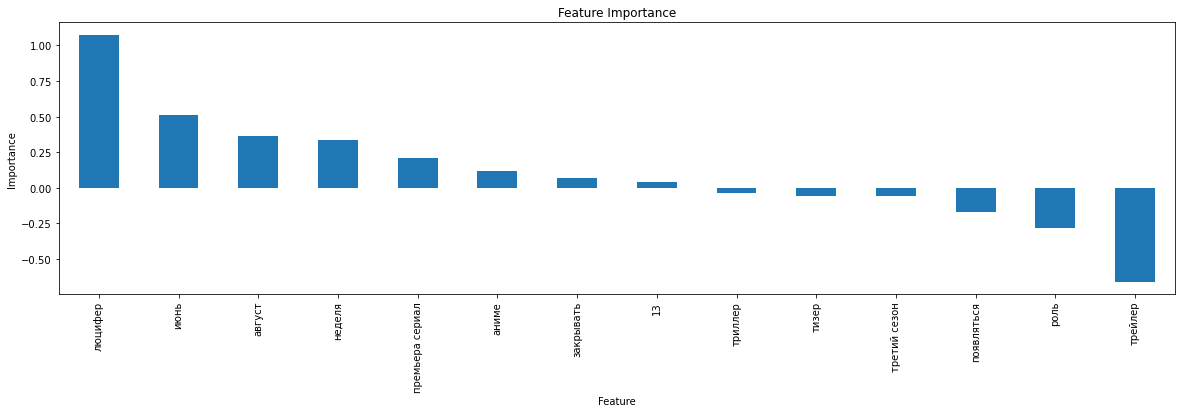

In [46]:
load_data_and_process('title', 'comments_count')

Теперь попробуем поиграть с параметрами tf-idf преобразования.

Best Score:  0.0208978501516651
Best Params:  {'alpha': 0.41000000000000003}
  error_type   Regressor
0        MAE    6.335576
1        MSE  100.192978
2         R2    0.036204


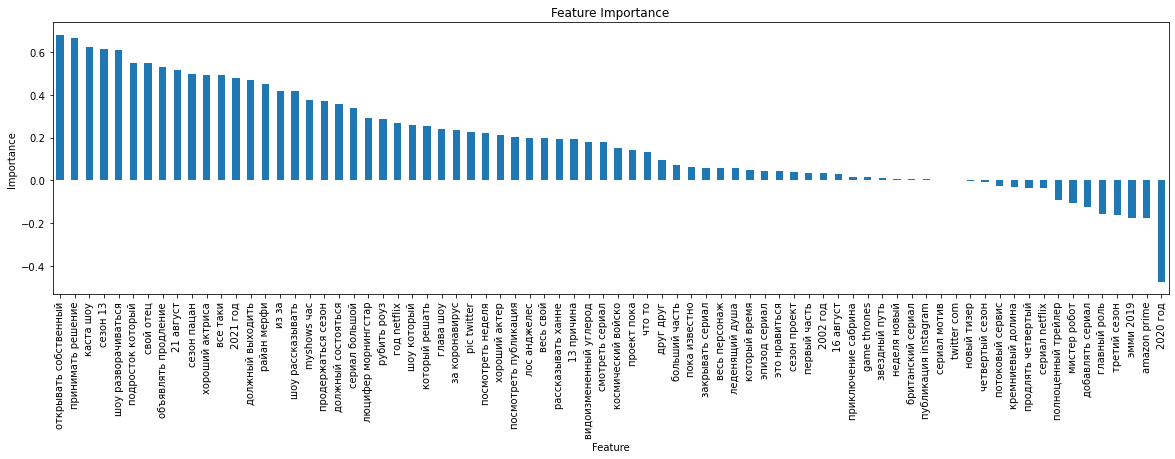

In [47]:
load_data_and_process('full_text', 'comments_count', ngram_range=(2,2))

Best Score:  0.012819419944587174
Best Params:  {'alpha': 0.31000000000000005}
  error_type   Regressor
0        MAE    6.739598
1        MSE  103.525195
2         R2    0.004151


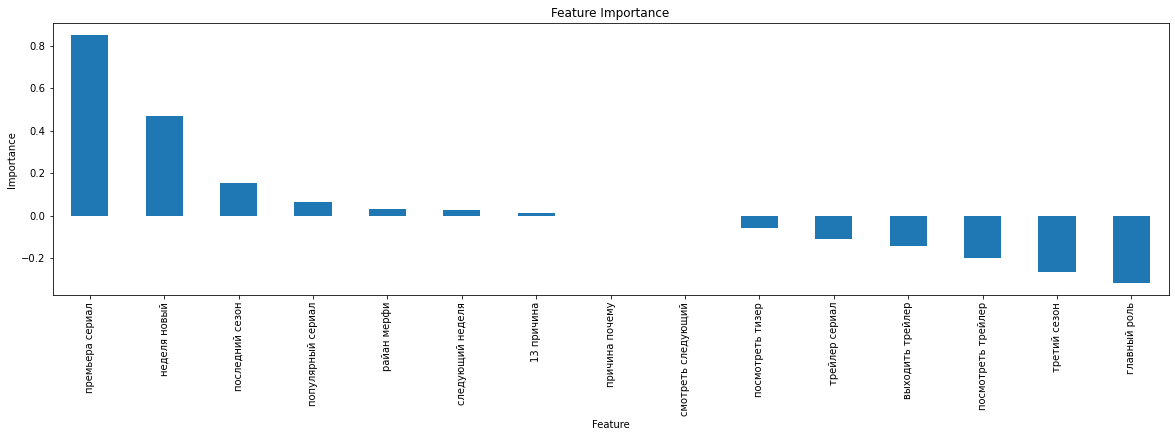

In [48]:
load_data_and_process('title', 'comments_count', ngram_range=(2,2))

Best Score:  0.021603533791359576
Best Params:  {'alpha': 0.41000000000000003}
  error_type   Regressor
0        MAE    6.333298
1        MSE  100.164530
2         R2    0.036478


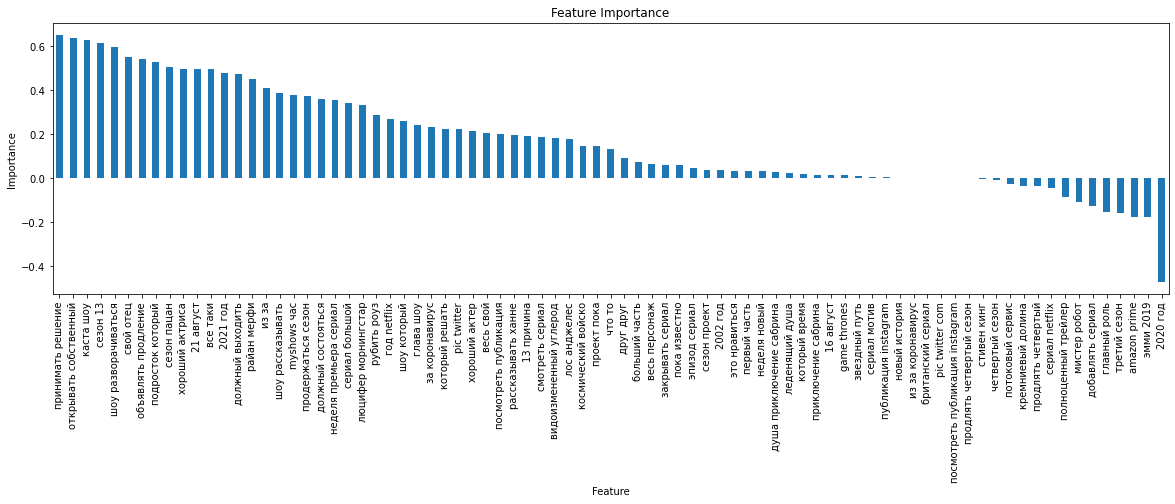

In [49]:
load_data_and_process('full_text', 'comments_count', ngram_range=(2,3))

Best Score:  0.011444789501909015
Best Params:  {'alpha': 0.31000000000000005}
  error_type   Regressor
0        MAE    6.739972
1        MSE  103.525604
2         R2    0.004147


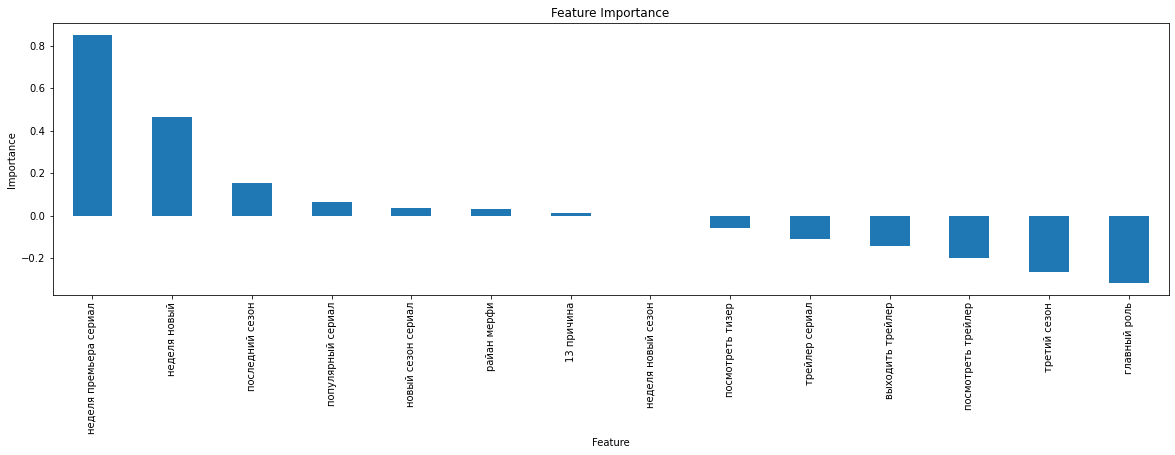

In [50]:
load_data_and_process('title', 'comments_count', ngram_range=(2,3))

Best Score:  0.07158840472571097
Best Params:  {'alpha': 0.51}
  error_type  Regressor
0        MAE   6.112493
1        MSE  81.515532
2         R2   0.215870


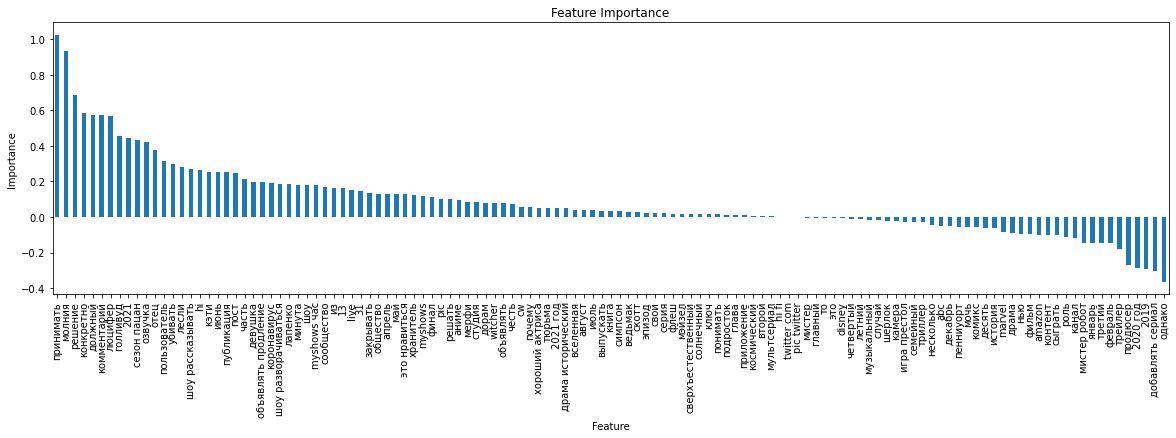

In [51]:
load_data_and_process('full_text', 'comments_count', max_df=0.9, min_df=2, ngram_range=(1,2))

Best Score:  0.027839359374536944
Best Params:  {'alpha': 0.31000000000000005}
  error_type   Regressor
0        MAE    6.650820
1        MSE  102.264740
2         R2    0.016275


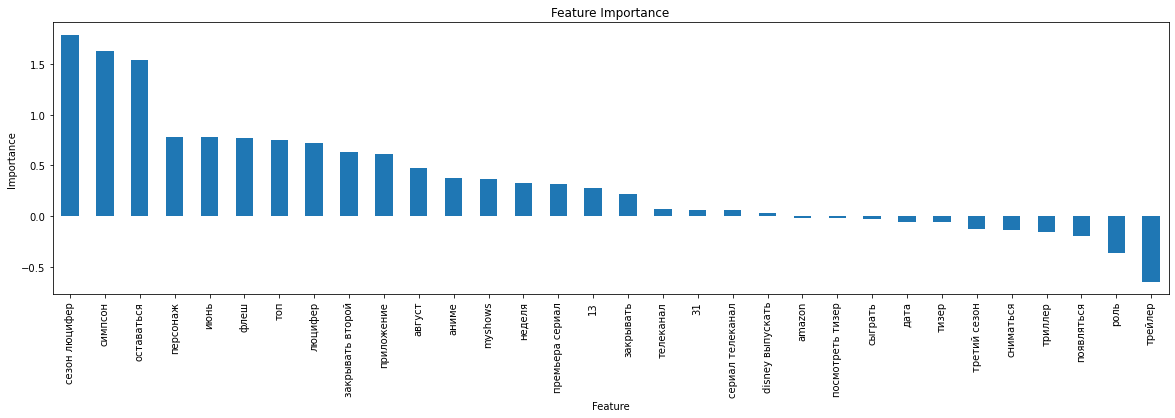

In [52]:
load_data_and_process('title', 'comments_count', max_df=0.9, min_df=2, ngram_range=(1,2))

Best Score:  0.07058287416899027
Best Params:  {'alpha': 0.7100000000000001}
  error_type  Regressor
0        MAE   6.269327
1        MSE  86.391734
2         R2   0.168964


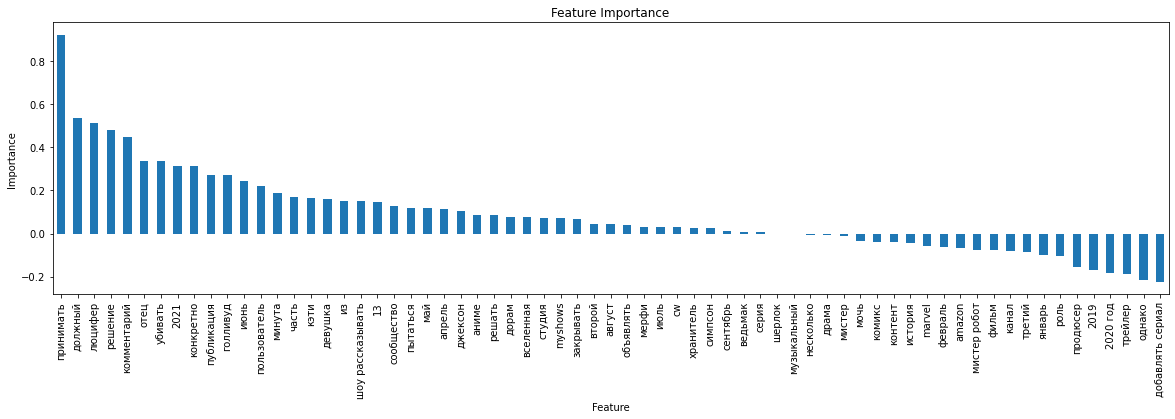

Best Score:  0.01524963140343678
Best Params:  {'alpha': 0.31000000000000005}
  error_type   Regressor
0        MAE    6.695203
1        MSE  102.190652
2         R2    0.016988


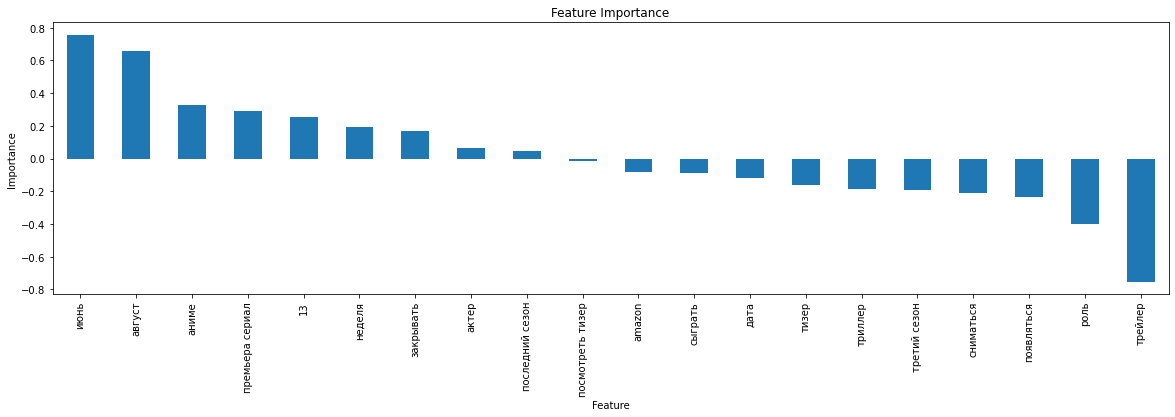

In [53]:
load_data_and_process('full_text', 'comments_count', max_df=0.5, min_df=10, ngram_range=(1,2))
load_data_and_process('title', 'comments_count', max_df=0.5, min_df=10, ngram_range=(1,2))

Best Score:  0.07018272361058953
Best Params:  {'alpha': 0.6100000000000001}
  error_type  Regressor
0        MAE   6.178229
1        MSE  83.890045
2         R2   0.193029


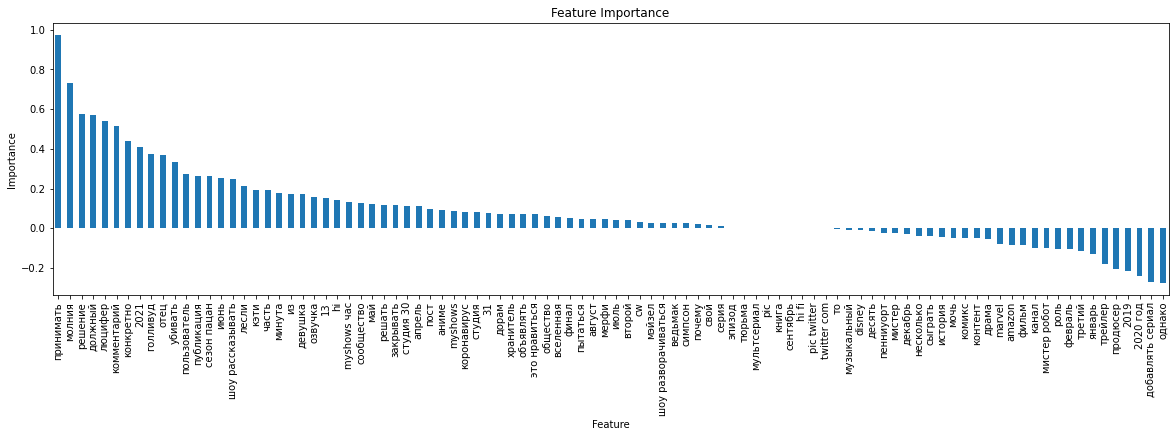

Best Score:  0.025322512001731877
Best Params:  {'alpha': 0.41000000000000003}
  error_type   Regressor
0        MAE    6.695069
1        MSE  102.795304
2         R2    0.011172


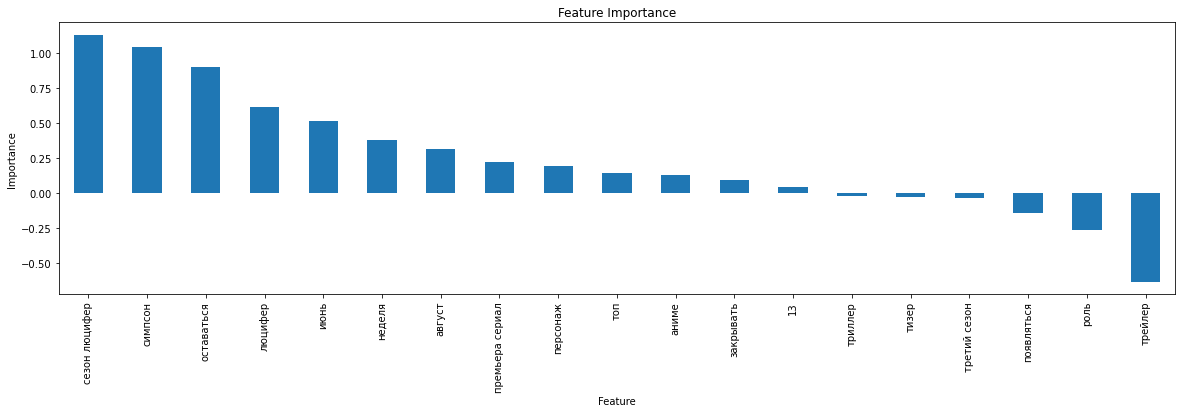

In [54]:
load_data_and_process('full_text', 'comments_count', max_df=0.5, min_df=3, ngram_range=(1,2))
load_data_and_process('title', 'comments_count', max_df=0.5, min_df=3, ngram_range=(1,2))